In [2]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np
import torch
import pandas as pd


def set_random_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)

set_random_seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Hyperparameters and Constants

Here, we define wether to train the model or not and for how many epochs to train for.

If `TRAIN = False`, then the last trained model will be used for inference in the notebook if run end to end.

In [ ]:
TRAIN = True
# Number of epochs to train for.
EPOCHS = 50

## Download and Prepare the Dataset


Let's download the dataset.

In [ ]:
if not os.path.exists('train'):

    !curl -L 'https://app.roboflow.com/ds/Gi7A06UnbM?key=fl4u4rF4Eq' > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

The dataset is structured in the following manner:

```
├── data.yaml
├── README.dataset.txt
├── README.roboflow.txt
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
└── valid
    ├── images
    └── labels

```

## Helper Functions to Download Files

The following function is for downloading any file in the notebook. In further sections of the notebook, we will use it for downloading the inference data.

In [ ]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)
    else:
        print('File already present, skipping download...')

### The Dataset YAML File

The dataset YAML (`data.yaml`) file containing the path to the training and validation images and labels is already provided. This file will also contain the class names from the dataset.

The dataset contains 3 classes: **'bridge', 'gap', 'sraf'**.

The following block shows the contents of the `data.yaml` file.

```yaml
train: ../train/images
val: ../valid/images

nc: 3
names: ['bridge', 'gap', 'sraf']
```



### Visualize a Few Ground Truth Images

Before moving forward, let's check out few of the ground truth images.

The current annotations in the text files are in normalized `[x_center, y_center, width, height]` format. Let's write a function that will convert it back to `[x_min, y_min, x_max, y_max]` format.

In [3]:
class_names = ['bridge', 'gap', 'sraf']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [4]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [5]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin

        class_name = class_names[int(labels[box_num])]

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=3
        )

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name,
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image,
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image,
            class_name,
            (xmin, ymin - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [6]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()

    num_images = len(all_training_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 4, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

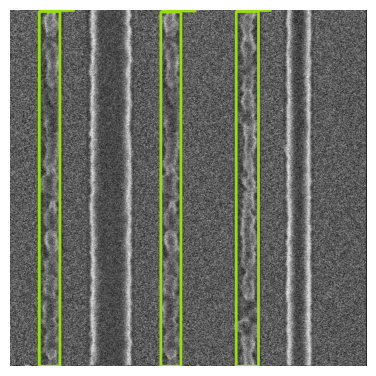

In [8]:
# Visualize a few training images.
plot(
    image_paths='train/images/*',
    label_paths='train/labels/*',
    num_samples=1
)

## Helper Functions for Logging

Here, we write the helper functions that we need for logging of the results in the notebook while training the models.

Let's create our custom result directories so that we can easily keep track of them and carry out inference using the proper model.

In [ ]:
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

**Function to Monitor TensorBoard logs**.

## Clone YOLOV5 Repository

In [10]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 16280, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 16280 (delta 74), reused 89 (delta 31), pack-reused 16103
Receiving objects: 100% (16280/16280), 15.10 MiB | 19.31 MiB/s, done.
Resolving deltas: 100% (11109/11109), done.


In [11]:
%cd /content/yolov5
!pwd

/content/yolov5
/content/yolov5


In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install wandb

## Training using YOLOV5

The next step is to train the neural network model.

### Train a Small (yolov5s) Model

Training all the layers of the small model.

**All possible keys for running 'train.py' script:**

- `weights`, type=str, default=ROOT / "yolov5s.pt", help="initial weights path"
- `cfg`, type=str, default="", help="model.yaml path"
- `data`, type=str, default=ROOT / "data/coco128.yaml" help="dataset.yaml path"
- `hyp`, type=str, default=ROOT / "data/hyps/hyp.scratch-low.yaml", help="hyperparameters path"
- `epochs`, type=int, default=100, help="total training epochs"
- `batch-size`, type=int, default=16, help="total batch size for all GPUs, -1 for autobatch"
- `imgsz`, "--img", "--img-size", type=int, default=640, help="train, val image size (pixels)"
- `rect`, action="store_true", help="rectangular training"
- `resume`, nargs="?", const=True, default=False, help="resume most recent training"
- `nosave`, action="store_true", help="only save final checkpoint"
- `noval`, action="store_true", help="only validate final epoch"
- `noautoanchor`, action="store_true", help="disable AutoAnchor"
- `evolve`, type=int, nargs="?", const=300, help="evolve hyperparameters for x generations"
- `resume_evolve`, type=str, default=None, help="resume evolve from last generation"

- `bucket`, type=str, default="", help="gsutil bucket"
- `cache`, type=str, nargs="?", const="ram", help="image --cache ram/disk"
- `image-weights`, action="store_true", help="use weighted image selection for training"
- `device`, default="", help="cuda device, i.e. 0 or 0,1,2,3 or cpu"
- `multi-scale` action="store_true", help="vary img-size +/- 50%%"
- `single-cls`, action="store_true", help="train multi-class data as single-class"
- `optimizer`, type=str, choices=["SGD", "Adam", "AdamW"], default="SGD", help="optimizer"
- `sync-bn`, action="store_true", help="use SyncBatchNorm, only available in DDP mode"
- `workers`, type=int, default=8, help="max dataloader workers (per RANK in DDP mode)"
- `project`, default=ROOT / "runs/train", help="save to project/name"
- `name`, default="exp", help="save to project/name"
- `exist-ok`, action="store_true", help="existing project/name ok, do not increment"
- `quad`, action="store_true", help="quad dataloader"
- `cos-lr`, action="store_true", help="cosine LR scheduler"
- `label-smoothing`, type=float, default=0.0, help="Label smoothing epsilon"
- `patience`, type=int, default=100, help="EarlyStopping patience (epochs without improvement)"
- `freeze`, nargs="+", type=int, default=[0], help="Freeze layers: backbone=10, first3=0 1 2"
- `save-period`, type=int, default=-1, help="Save checkpoint every x epochs (disabled if < 1)"
- `seed`, type=int, default=0, help="Global training seed"
- `local_rank`, type=int, default=-1, help="Automatic DDP Multi-GPU argument, do not modify"

**Logger arguments**
- `entity`, default=None, help="Entity"
- `upload_dataset`, nargs="?", const=True, default=False, help='Upload data, "val" option'
- `bbox_interval`, type=int, default=-1, help="Set bounding-box image logging interval"
- `artifact_alias`, type=str, default="latest", help="Version of dataset artifact to use"



In [ ]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data ../data.yaml --weights yolov5s.pt \
    --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR}\
    --bbox_interval 1

Run the cell below if you want to save your model to google drive:

In [ ]:
%cp /content/yolov5/runs/train/results_1/weights/yolov5s_tuned_datav6_val.pt /content/drive/MyDrive/models

**All posible keys for running 'val.py' script:**

-    `data` - your data yaml file
-    `weights=None` - model.pt path(s)
-    `batch_size=32` - batch size
-    `imgsz=640` -  inference size (pixels)
-    `conf_thres=0.001` - confidence threshold
-    `iou_thres=0.6` -  NMS IoU threshold
-    `max_det=300` - maximum detections per image
-    `task="val"` - train, val, test, speed or study
-    `device=""` - cuda device, i.e. 0 or 0,1,2,3 or cpu
-    `workers=8` - max dataloader workers (per RANK in DDP mode)
-    `single_cls=False` - treat as single-class dataset
-    `augment=False` - augmented inference
-    `verbose=False` - verbose output
-    `save_txt=False` - save results to *.txt
-    `save_hybrid=False` - save label+prediction hybrid results to *.txt
-    `save_conf=False` - save confidences in --save-txt labels
-    `save_json=False` - save a COCO-JSON results file
-    `project=ROOT`- "runs/val",  # save to project/name
-    `name="exp"` - save to project/name
-    `exist_ok=False` - existing project/name ok, do not increment
-    `half=True` - use FP16 half-precision inference
-    `dnn=False` - use OpenCV DNN for ONNX inference
-    `model=None`,
-   `dataloader=None`,
-    `save_dir=Path("")`,
-    `plots=True`,
-    `callbacks=Callbacks()`,
-    `compute_loss=None`,



In [ ]:
!python val.py --weights /content/drive/MyDrive/models/yolov5s_datav6.pt --data ../data.yaml

val: data=../data.yaml, weights=['/content/drive/MyDrive/models/yolov5s_datav6.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-249-gf400bba Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/valid/labels.cache... 83 images, 15 backgrounds, 0 corrupt: 100% 83/83 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 3/3 [00:04<00:00,  1.62s/it]
                   all         83        290      0.854      0.892      0.914      0.534
                bridge         83         79      0.943      0.962      0.979      0.555
                   gap         83     

Create dataframe with metrics and save results to **'.csv'** file.

In [ ]:
validation_result = pd.DataFrame({
    'Class': ['all', 'bridge','gap','sraf'],
    'Images':[83,83,83,83],
    'Instances':[290,79,85,126],
    'P':[0.854,0.943, 0.654, 0.966],
    'R':[0.892, 0.962,0.777, 0.937],
    'mAP50':[0.914, 0.979, 0.806, 0.958],
    'mAP50-95':[0.534, 0.555, 0.438, 0.609]
})

validation_result.to_csv('/content/drive/MyDrive/metrics/yolov5s_data_v5_val.csv')

Save all outputs and predictoins from validation mode:

In [ ]:
%cp -r /content/yolov5/runs/val/yolov5s_data_v5_val/ /content/drive/MyDrive/inference_outputs/YOLO_V5

### Check Out the Validation Predictions and Inference

In this section, we will check out and visualize the predictions of the validation images saved during training. Along with that, we will also check out inference of images.

### Visualization and Inference Utilities

We will visualize the validation prediction images that are saved during training. The following is the function for that.

In [ ]:
!ls runs/train/results_1/

confusion_matrix.png				    PR_curve.png	   val_batch0_pred.jpg
events.out.tfevents.1699088702.32264d55b80f.1033.0  R_curve.png		   val_batch1_labels.jpg
F1_curve.png					    results.csv		   val_batch1_pred.jpg
hyp.yaml					    results.png		   val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch0.jpg	   val_batch2_pred.jpg
labels.jpg					    train_batch1.jpg	   weights
opt.yaml					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


In [ ]:
search_png = glob.glob("runs/train/results_1/*.png")
print(search_png)


['runs/train/results_1/R_curve.png', 'runs/train/results_1/F1_curve.png', 'runs/train/results_1/confusion_matrix.png', 'runs/train/results_1/PR_curve.png', 'runs/train/results_1/results.png', 'runs/train/results_1/P_curve.png']


In [ ]:
# Function to show validation predictions saved during training.
def show_valid_results(RES_DIR):
    !ls runs/train/{RES_DIR}
    EXP_PATH = f"runs/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

The following functions are for carrying out inference on images and videos.

In [ ]:
# Helper function for inference on images.
def inference(RES_DIR, data_path):
    # Directory to store inference results.
    infer_dir_count = len(glob.glob('runs/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Inference on images.
    !python detect.py --weights runs/train/{RES_DIR}/weights/best.pt \
    --source {data_path} --name {INFER_DIR} --conf 0.5
    return INFER_DIR

We may also need to visualize images in any of the directories. The following function accepts a directory path and plots all the images in them.

In [ ]:
from IPython.display import Image, display

def visualize(INFER_DIR):
# Visualize inference images.
    INFER_PATH = f"runs/detect/{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*.jpg")
    print(infer_images)
    for pred_image in infer_images:
      display(Image(filename=pred_image))
      print('\n')
        # image = cv2.imread(pred_image)
        # plt.figure(figsize=(10, 10))
        # plt.imshow(image[:, :, ::-1])
        # plt.axis('off')
        # plt.show()

**Visualize validation prediction images.**

In [ ]:
show_valid_results(RES_DIR)

### Inference
In this section, we will carry out inference on unseen images and videos from the internet.

The images for inference are in the `inference_images` directory.



### Inference on Images

**To carry out inference on images, we just need to provide the directory path where all the images are stored, and inference will happen on all images automatically.**

In [ ]:
# Inference on images.
IMAGE_INFER_DIR = inference(RES_DIR, '/content/test/images/')

In [ ]:
visualize(IMAGE_INFER_DIR)

In [ ]:
!python val.py --task test --weights /content/yolov5/runs/train/results_1/weights/best.pt --data ../data.yaml

val: data=../data.yaml, weights=['/content/yolov5/runs/train/results_1/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-245-g3d8f004 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/test/labels... 37 images, 3 backgrounds, 0 corrupt: 100% 37/37 [00:00<00:00, 351.05it/s]
test: New cache created: /content/test/labels.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 2/2 [00:01<00:00,  1.23it/s]
                   all         37        149      0.884      0.876      0.916      0.516
                bridge         37         45      0.914      0.933 

Сохраняем результаты инференса на google-drive:

In [ ]:
%cp -r /content/yolov5/runs/detect/yolov5s_datav5_infer /content/drive/MyDrive/inference_outputs/YOLO_V5

In [ ]:
test_result = pd.DataFrame({
    'Class': ['all', 'bridge','gap','sraf'],
    'Images':[37,37,37,37],
    'Instances':[149,45,53,51],
    'P':[0.884,0.914, 0.883, 0.857],
    'R':[0.876, 0.933,0.851, 0.843],
    'mAP50':[0.916, 0.956, 0.91, 0.883],
    'mAP50-95':[0.516, 0.536,0.527, 0.484]
})

test_result.to_csv('/content/drive/MyDrive/metrics/yolov5s_data_v5_test.csv')

In [ ]:
%cp /content/yolov5/runs/train/results_1/weights/yolov5s_datav6.pt /content/drive/MyDrive/models

## Training and Inference using  Medium Model

In [ ]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data ../data.yaml --weights yolov5m.pt \
    --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR}


In [ ]:
RES_DIR


'results_1'

In [ ]:
show_valid_results(RES_DIR)

In [ ]:
validation_result = pd.DataFrame({
    'Class': ['all', 'bridge','gap','sraf'],
    'Images':[83,83,83,83],
    'Instances':[290,79,85,126],
    'P':[0.853,0.886, 0.729, 0.943],
    'R':[0.873, 0.962,0.753, 0.905],
    'mAP50':[0.928, 0.983, 0.83, 0.971],
    'mAP50-95':[0.556, 0.579, 0.435, 0.653]
})

validation_result.to_csv('/content/drive/MyDrive/metrics/yolov5m_data_v6_val_optim.csv')

In [ ]:
!python val.py --weights /content/yolov5/runs/train/results_1/weights/best.pt --data ../data.yaml

val: data=../data.yaml, weights=['/content/yolov5/runs/train/results_1/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-247-g3f02fde Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 212 layers, 20882568 parameters, 0 gradients, 48.0 GFLOPs
val: Scanning /content/valid/labels.cache... 83 images, 15 backgrounds, 0 corrupt: 100% 83/83 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 3/3 [00:03<00:00,  1.29s/it]
                   all         83        290      0.853      0.873      0.928      0.556
                bridge         83         79      0.886      0.962      0.983      0.579
                   gap         8

In [ ]:
%cp -r /content/yolov5/runs/val/yolov5m_data_v5_val/ /content/drive/MyDrive/inference_outputs/YOLO_V5

In [ ]:
# Inference on images.
IMAGE_INFER_DIR = inference(RES_DIR, '/content/test/images/')

In [ ]:
visualize(IMAGE_INFER_DIR)

In [ ]:
!python val.py --task test --weights /content/yolov5/runs/train/results_1/weights/best.pt --data ../data.yaml

val: data=../data.yaml, weights=['/content/yolov5/runs/train/results_1/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-247-g3f02fde Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 212 layers, 20882568 parameters, 0 gradients, 48.0 GFLOPs
test: Scanning /content/test/labels... 37 images, 3 backgrounds, 0 corrupt: 100% 37/37 [00:00<00:00, 282.35it/s]
test: New cache created: /content/test/labels.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 2/2 [00:02<00:00,  1.30s/it]
                   all         37        149      0.897      0.863      0.925      0.552
                bridge         37         45      0.904      0.978

In [ ]:
%cp -r /content/yolov5/runs/detect/yolov5m_datav5_infer /content/drive/MyDrive/inference_outputs/YOLO_V5

In [ ]:
test_result = pd.DataFrame({
    'Class': ['all', 'bridge','gap','sraf'],
    'Images':[37,37,37,37],
    'Instances':[149,45,53,51],
    'P':[0.897,0.904, 0.893, 0.893],
    'R':[0.863, 0.978, 0.791, 0.819],
    'mAP50':[0.925, 0.97, 0.899, 0.907],
    'mAP50-95':[0.552, 0.561, 0.519, 0.577]
})

test_result.to_csv('/content/drive/MyDrive/metrics/yolov5m_data_v6_test_optim.csv')

In [ ]:
%cp /content/yolov5/runs/train/results_2/weights/yolov5m_datav6.pt /content/drive/MyDrive/models/

# Train and inference using large model

In [ ]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data ../data.yaml --weights yolov5l.pt \
    --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR}\
    --bbox_interval 1

In [ ]:
validation_result = pd.DataFrame({
    'Class': ['all', 'bridge','gap','sraf'],
    'Images':[83,83,83,83],
    'Instances':[290,79,85,126],
    'P':[0.848,0.869, 0.732, 0.944],
    'R':[0.843, 0.962,0.624, 0.944],
    'mAP50':[0.898, 0.986, 0.743, 0.964],
    'mAP50-95':[0.545, 0.593, 0.38, 0.663]
})

validation_result.to_csv('/content/drive/MyDrive/metrics/yolov5l_data_v6_val_optim.csv')

In [ ]:
show_valid_results(RES_DIR)

In [ ]:
!python val.py  --weights /content/yolov5/runs/train/results_2/weights/best.pt --data ../data.yaml --batch-size 16

val: data=../data.yaml, weights=['/content/yolov5/runs/train/results_2/weights/best.pt'], batch_size=1, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-247-g3f02fde Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 267 layers, 46119048 parameters, 0 gradients, 107.7 GFLOPs
val: Scanning /content/valid/labels.cache... 83 images, 15 backgrounds, 0 corrupt: 100% 83/83 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 83/83 [00:03<00:00, 21.95it/s]
                   all         83        290      0.848      0.843      0.898      0.545
                bridge         83         79      0.869      0.962      0.986      0.593
                   gap        

In [ ]:
%cp -r /content/yolov5/runs/val/yolov5l_data_v5_val/ /content/drive/MyDrive/inference_outputs/YOLO_V5

In [ ]:
!python val.py --task test --weights /content/yolov5/runs/train/results_2/weights/best.pt --data ../data.yaml

val: data=../data.yaml, weights=['/content/yolov5/runs/train/results_2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-247-g3f02fde Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 267 layers, 46119048 parameters, 0 gradients, 107.7 GFLOPs
test: Scanning /content/test/labels.cache... 37 images, 3 backgrounds, 0 corrupt: 100% 37/37 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 2/2 [00:02<00:00,  1.22s/it]
                   all         37        149      0.848      0.833      0.907      0.511
                bridge         37         45      0.904      0.978      0.965      0.499
                   gap         

In [ ]:
# Inference on images.
IMAGE_INFER_DIR = inference(RES_DIR, '/content/test/images/')

In [ ]:
visualize(IMAGE_INFER_DIR)

In [ ]:
%cp -r /content/yolov5/runs/detect/yolov5l_data_v5_infer /content/drive/MyDrive/inference_outputs/YOLO_V5

In [ ]:
test_result = pd.DataFrame({
    'Class': ['all', 'bridge','gap','sraf'],
    'Images':[44,44,44,44],
    'Instances':[149,45,53,51],
    'P':[0.848,0.904, 0.914, 0.727],
    'R':[0.833, 0.978,0.698, 0.824],
    'mAP50':[0.907, 0.965,  0.876, 0.879],
    'mAP50-95':[0.511, 0.499, 0.493, 0.541]
})

test_result.to_csv('/content/drive/MyDrive/metrics/yolov5l_data_v6_test_optim.csv')

In [ ]:
%cp /content/yolov5/runs/train/results_3/weights/yolov5l_datav6.pt /content/drive/MyDrive/models

# Tuning hyperparameters


In this section we optimize hyperparameters for YoloV5 using generic algorithm.

Firtly we define `fitness` function  for a model depending on what metric is more important to maximize: apply weight to **Precision**, **Recall**, **mAP_0.5** and **mAP_0.5-0.95**.

After that the generic algorihtm is applied to search the best configuration of hyperparameters value. You can run hyperparameter search the same way as the training run but also adding two additional keys: `cache`, `evolve`.

For more details on tuning hyps for yolo read this section: [section](https://docs.ultralytics.com/yolov5/tutorials/hyperparameter_evolution/#3-evolve)

In [ ]:
def fitness(x):
    # Model fitness as a weighted combination of metrics
    w = [0.0, 0.0, 0.6, 0.4]  # weights for [P, R, mAP@0.5, mAP@0.5:0.95]
    return (x[:, :4] * w).sum(1)


In [ ]:
RES_DIR = set_res_dir()

Current number of result directories: 0
results_1


In [ ]:
!python train.py --epochs 10 --data ../data.yaml --weights yolov5s.pt --cache --evolve 30

In [ ]:
%cp -r /content/yolov5/runs/evolve/yolov5s_datav6_hyps /content/drive/MyDrive/hyperparameters

In [ ]:
from utils import plots
plots.plot_evolve('/content/yolov5/runs/evolve/exp6/evolve.csv')

Best results from row 12 of /content/yolov5/runs/evolve/exp6/evolve.csv:
            lr0: 0.0115
            lrf: 0.01
       momentum: 0.933
   weight_decay: 0.00048
  warmup_epochs: 3.37
warmup_momentum: 0.95
 warmup_bias_lr: 0.101
            box: 0.05
            cls: 0.571
         cls_pw: 0.999
            obj: 0.839
         obj_pw: 1.24
          iou_t: 0.2
       anchor_t: 3.17
       fl_gamma: 0
          hsv_h: 0.0113
          hsv_s: 0.824
          hsv_v: 0.318
        degrees: 0
      translate: 0.116
          scale: 0.523
          shear: 0
    perspective: 0
         flipud: 0
         fliplr: 0.5
         mosaic: 0.697
          mixup: 0
     copy_paste: 0
        anchors: 4.94
Saved /content/yolov5/runs/evolve/exp6/evolve.png


# WandB inference with trained model




In [ ]:
!pip install -U ultralytics


In [9]:
!wandb login

wandb: Currently logged in as: andrew_mskv (ml_team_mskv). Use `wandb login --relogin` to force relogin


In [10]:
import wandb
run = wandb.init()
artifact = run.use_artifact('ml_team_mskv/YOLOv5/run_31xfkfqk_model:v0', type='model')
artifact_dir = artifact.download()

wandb: Currently logged in as: andrew_mskv (ml_team_mskv). Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


In [11]:
model_path = os.path.join(artifact_dir, 'best.pt')
model = torch.hub.load('ultralytics/yolov5', 'custom', path = model_path)


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-1-11 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 212 layers, 20861016 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


Now let's make sure that our trained model gives reproductible results. Run the  **val.py** script below and check the metrics:

In [ ]:
!python val.py --weights '/content/artifacts/run_31xfkfqk_model:v0/best.pt' --data ../data.yaml

val: data=../data.yaml, weights=['/content/yolov5/artifacts/run_rq4k72tk_model:v0/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 212 layers, 20865057 parameters, 0 gradients, 47.9 GFLOPs
100% 755k/755k [00:00<00:00, 14.8MB/s]
val: Scanning /content/valid/labels... 68 images, 17 backgrounds, 0 corrupt: 100% 68/68 [00:00<00:00, 1379.03it/s]
val: New cache created: /content/valid/labels.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 3/3 [00:05<00:00,  1.71s/it]
                   all         68        214      0.744      0.851      0.837      0.486
                bridge 

Run inference on a **single** image from test set:

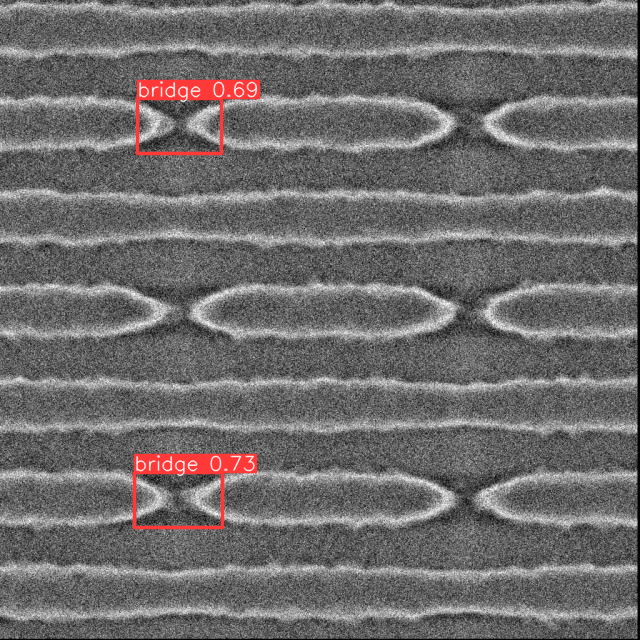

In [12]:
result = model('/content/test/images/S14_M0009-01MS_jpg.rf.14d746717c6ce42a6d6dd62004b42964.jpg')
result.show() # Other options: .show(), .save(), .crop(), .pandas(), etc.

Run inference on **multiple** images from test set:

['/content/test/images/E04_M0699-01MS_jpg.rf.f4acccd62867ff851afb74cdd80022df.jpg', '/content/test/images/S14_M0116-01MS_jpg.rf.c40acd4f6bb7d900eca39db948c1c62b.jpg', '/content/test/images/S14_M1294-01MS_jpg.rf.102c3b2be24eacd90d0faa95c67bd780.jpg', '/content/test/images/S04_M0058-01MS_jpg.rf.c5e87782f8a5819149e05b7b39e3c986.jpg', '/content/test/images/E04_M0176-01MS_jpg.rf.d9b9974f1012895780290816331d1322.jpg', '/content/test/images/S14_M0139-01MS_jpg.rf.ff36e9d3a19e8b0a0caf1720eaed4844.jpg', '/content/test/images/S14_M0110-01MS_jpg.rf.de86b348f3140900fa57475d6a189cfe.jpg', '/content/test/images/E04_M0849-01MS_jpg.rf.4e0e29ce30ec394a7255f4150a6bac29.jpg', '/content/test/images/S14_M0133-01MS_jpg.rf.b05355271feb65d5d86ba9addb7f6272.jpg', '/content/test/images/S04_M0021-01MS_jpg.rf.09231f4919ead73dcb283f42b4f1f2f4.jpg', '/content/test/images/S14_M0176-01MS_jpg.rf.95d3c670fc2c10901695654deb5d8e00.jpg', '/content/test/images/S14_M0165-01MS_jpg.rf.619b573484482989cf17aff7b20c5ea4.jpg', '/c

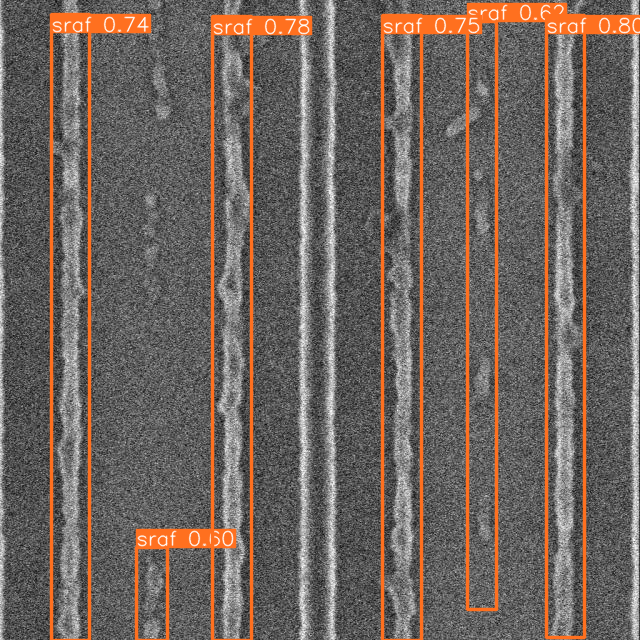

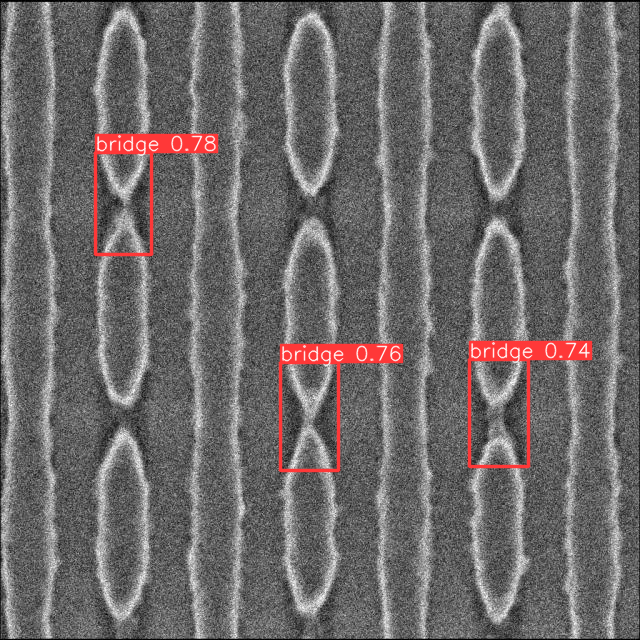

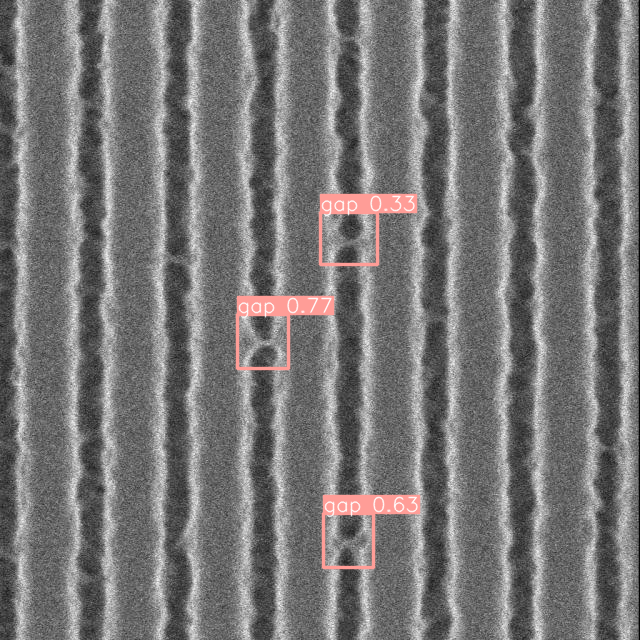

In [13]:
from PIL import Image

INFER_DIR = "/content/test/images"
infer_images = glob.glob(f"{INFER_DIR}/*.jpg")
print(infer_images)


for i,image in enumerate(infer_images):
  pred_image = Image.open(image)
  result = model(pred_image)
  result.show()
  print('\n')
  if i == 2:
    break


# Model ensembling

In [ ]:
!pip install -U ultralytics

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb
run_small = wandb.init()
artifact_medium = run_small.use_artifact('ml_team_mskv/YOLOv5/run_mcxtfgnq_model:v0', type='model')
artifact_dir_medium = artifact_medium.download()


In [ ]:
run_large = wandb.init()
artifact_large = run_large.use_artifact('ml_team_mskv/YOLOv5/run_qzvkw68l_model:v0', type='model')
artifact_dir_large = artifact_large.download()

In [ ]:
!python val.py --weights /content/yolov5/runs/train/results_2/weights/yolov5m_datav6.pt /content/yolov5/runs/train/results_3/weights/yolov5l_datav6.pt \
--data ../data.yaml\
--batch-size 1

val: data=../data.yaml, weights=['/content/yolov5/runs/train/results_2/weights/yolov5m_datav6.pt', '/content/yolov5/runs/train/results_3/weights/yolov5l_datav6.pt'], batch_size=1, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-245-g3d8f004 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 212 layers, 20861016 parameters, 0 gradients, 47.9 GFLOPs
Fusing layers... 
Model summary: 267 layers, 46119048 parameters, 0 gradients, 107.7 GFLOPs
Ensemble created with ['/content/yolov5/runs/train/results_2/weights/yolov5m_datav6.pt', '/content/yolov5/runs/train/results_3/weights/yolov5l_datav6.pt']

val: Scanning /content/valid/labels.cache... 83 images, 15 backgrounds, 0 corrupt: 100% 83/83 [00:00<?, ?it/s]
           

In [ ]:
validation_result = pd.DataFrame({
    'Class': ['all', 'bridge','gap','sraf'],
    'Images':[83,83,83,83],
    'Instances':[290,79,85,126],
    'P':[0.871,0.901,0.769, 0.944],
    'R':[0.861, 0.949, 0.704, 0.929],
    'mAP50':[0.921, 0.981, 0.808, 0.975],
    'mAP50-95':[0.527, 0.541, 0.424, 0.616]
})

validation_result.to_csv('/content/drive/MyDrive/metrics/med_large_ensemble_data_v6_val.csv')

In [ ]:
!python val.py --task test --weights /content/yolov5/runs/train/results_2/weights/yolov5m_datav6.pt /content/yolov5/runs/train/results_3/weights/yolov5l_datav6.pt\
--data ../data.yaml\
--batch-size 1

val: data=../data.yaml, weights=['/content/yolov5/runs/train/results_2/weights/yolov5m_datav6.pt', '/content/yolov5/runs/train/results_3/weights/yolov5l_datav6.pt'], batch_size=1, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-245-g3d8f004 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 212 layers, 20861016 parameters, 0 gradients, 47.9 GFLOPs
Fusing layers... 
Model summary: 267 layers, 46119048 parameters, 0 gradients, 107.7 GFLOPs
Ensemble created with ['/content/yolov5/runs/train/results_2/weights/yolov5m_datav6.pt', '/content/yolov5/runs/train/results_3/weights/yolov5l_datav6.pt']

test: Scanning /content/test/labels.cache... 37 images, 3 backgrounds, 0 corrupt: 100% 37/37 [00:00<?, ?it/s]
           

In [ ]:
test_result = pd.DataFrame({
    'Class': ['all', 'bridge','gap','sraf'],
    'Images':[37,37,37,37],
    'Instances':[149,45,53,51],
    'P':[0.825,0.908, 0.805,0.761],
    'R':[0.9, 0.978, 0.849, 0.873],
    'mAP50':[0.921, 0.967, 0.914,0.882],
    'mAP50-95':[0.543, 0.563, 0.52, 0.545]
})

test_result.to_csv('/content/drive/MyDrive/metrics/med_large_ensemble_data_v6_test.csv')

# Useful links



1.   https://github.com/ultralytics/yolov5 - official github repository
2.   https://docs.ultralytics.com/yolov5/ - YoloV5 docs with tutorials and many useful info
3.   https://docs.ultralytics.com/yolov5/tutorials/pytorch_hub_model_loading/#detailed-example - extended example on running inference on images
4.   https://docs.ultralytics.com/yolov5/tutorials/architecture_description/#41-compute-losses - architecture summary


